# XGBoost的智慧
XGBoost是相对GBDT的改进。
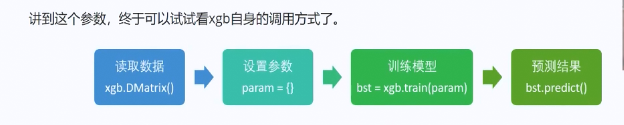

## **Param1**:选择弱评估器：booster
数据量不大：gbtree和dart是比较相似的。gblinear：数据是线性时才选用。不常用，但是要知道其用来选用弱评估器的参数。
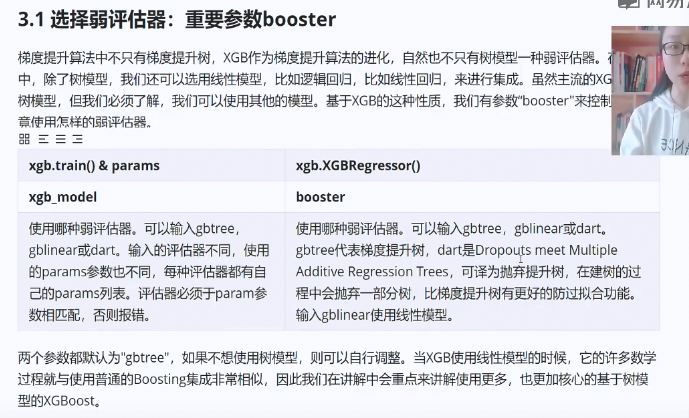


In [11]:
import xgboost as xgb
from xgboost import XGBRegressor as XGBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression as LinearR
from sklearn.datasets import load_boston
from sklearn.model_selection import KFold, cross_val_score as CVS, train_test_split as TTS
from sklearn.metrics import mean_squared_error as MSE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import datetime

In [5]:
data = load_boston()

In [6]:
X,y = data.data,data.target
Xtrain, Xtest, Ytrain, Ytest = TTS(X, y, test_size=0.3,random_state=420)
cv = KFold(n_splits=5,shuffle=True, random_state=420) # 交叉验证模式

In [7]:
for booster in ['gbtree', 'gblinear', 'dart']:
    reg = XGBR(n_estimators=100, random_state=420, booster=booster).fit(Xtrain,Ytrain)
    print('booster {}:{}'.format(booster,reg.score(Xtest,Ytest)))

booster gbtree:0.9050988954757183
booster gblinear:0.7082048198956812
booster dart:0.9050988727203699


## **Param2**: XGB的目标函数：重要参数objective
传统损失函数（RMSE：regression和log_loss：classification）+模型复杂度

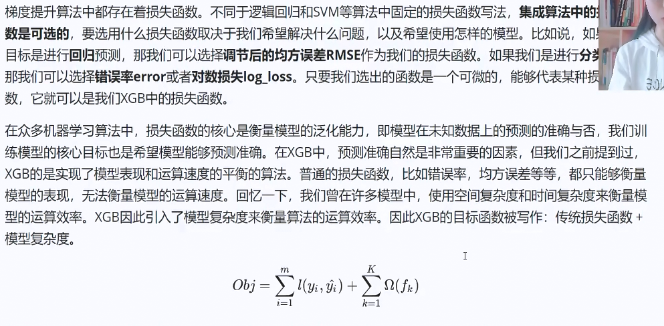
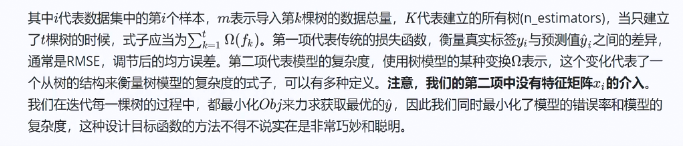
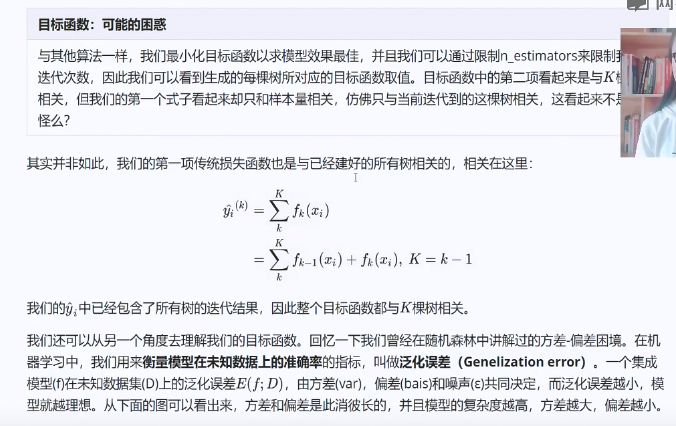
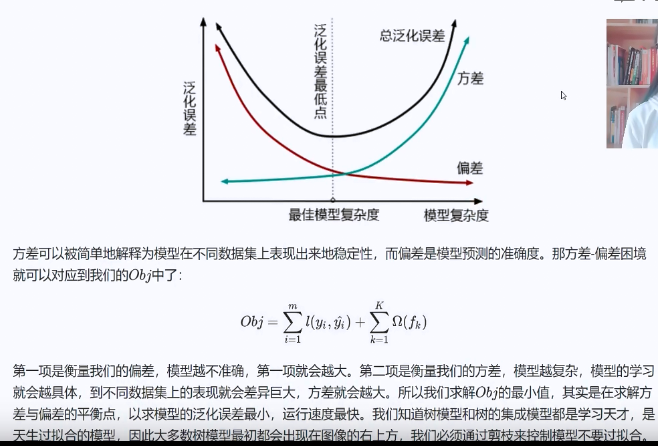
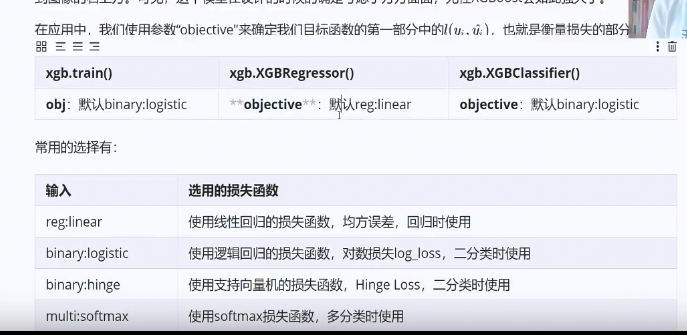
也可以自己定义损失函数$l(\hat{y}_i-y_i) = (\hat{y}_i-y_i)^2$
**注意**：分类型的目标函数（log_loss）导入回归类(MSE)会直接报错

In [9]:
# 默认reg:linear
reg = XGBR(n_estimators=190, random_state=430).fit(Xtrain,Ytrain)
reg.score(Xtest,Ytest)
MSE(Ytest, reg.predict(Xtest))


8.835224213421986

In [12]:
# 使用DMatrix读取数据
dtrain = xgb.DMatrix(Xtrain,Ytrain)
dtest = xgb.DMatrix(Xtest,Ytest)
dtrain

In [13]:
# 写参数
param = {'objective':'reg:squarederror','eta':0.1}
num_round = 180 # n_estimators

In [15]:
# 类train，可以直接拿来训练
bst = xgb.train(param, dtrain,num_round)

In [16]:
# 接口predict
preds = bst.predict(dtest)

In [17]:
preds

array([ 6.4613175, 22.123888 , 30.755163 , 13.424351 ,  8.378565 ,
       23.608477 , 14.2151165, 16.026499 , 15.498961 , 14.10649  ,
       24.030867 , 34.36362  , 21.461111 , 28.839497 , 19.568035 ,
       10.188658 , 19.42369  , 23.539951 , 22.850523 , 23.198708 ,
       17.82486  , 16.07219  , 27.602034 , 20.773046 , 20.868807 ,
       15.865789 , 22.076588 , 29.292158 , 22.841051 , 15.770392 ,
       36.680496 , 21.057947 , 20.137005 , 23.777853 , 22.70615  ,
       23.863268 , 15.595315 , 24.565872 , 17.720552 , 33.95111  ,
       18.784286 , 20.483374 , 37.10668  , 18.068268 , 12.73839  ,
       31.186407 , 45.895035 , 12.696718 , 10.773068 , 36.064293 ,
       26.262571 , 19.908836 , 20.715096 , 48.814903 , 27.550056 ,
       25.225826 , 17.15366  , 21.215551 , 17.426773 , 18.478971 ,
       14.6453705, 22.841473 , 18.869593 , 29.990978 , 29.933191 ,
       18.756853 , 18.784918 , 16.33361  , 23.155968 , 19.144344 ,
       29.724382 , 42.121906 , 31.544363 , 23.017508 , 19.5360

In [18]:
from sklearn.metrics import r2_score
r2_score(Ytest,preds)

0.9260984298390122

In [19]:
MSE(Ytest,preds)

6.87682821415069

**注意**：尽量使用xgb库本身来进行建模调参
### math:求解XGB的目标函数推导
重点：泰勒级数展开
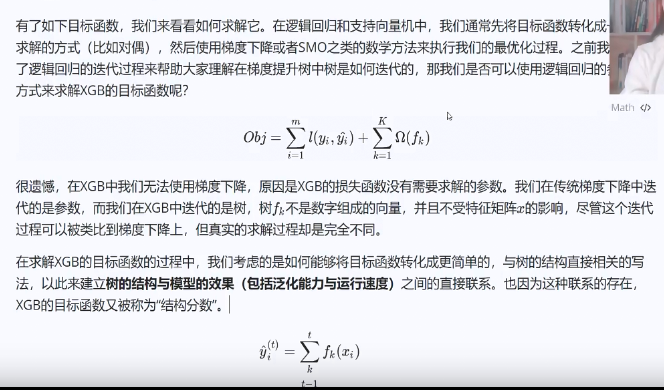
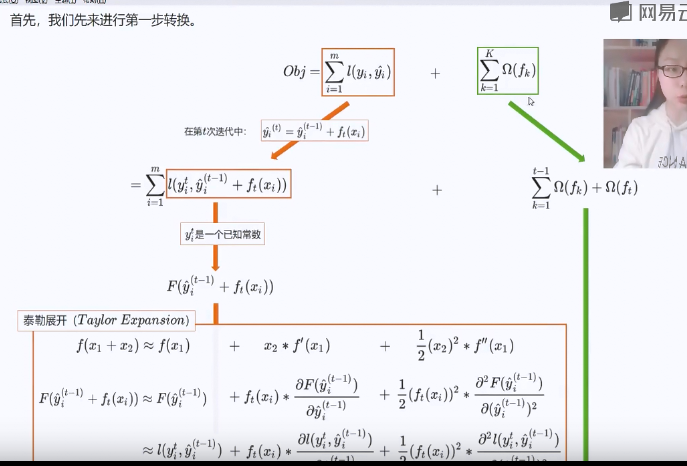
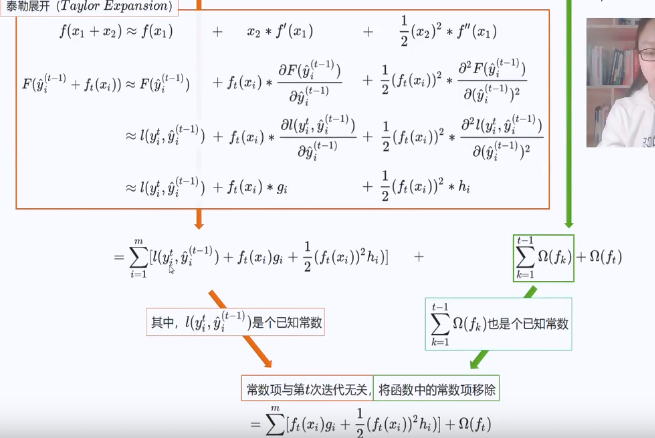
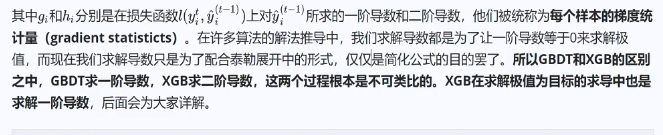
这个式子中$g_i$和$h_i$只与传统损失函数相关，核心部分时代决定的树$f_t$
> **注意**：GBDT求一阶导是为了让其等于0，求极值得到参数值；而XGBoost求hissen是为了将传统损失函数与树模型关联起来，两者不可类比。
## **Param3**: 参数化决策树$f_k(x)$：参数alpha,lambda
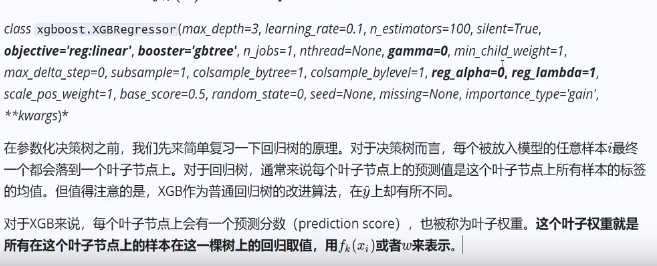